In [1]:
import json
import logging

import config
import polars as pl
from catboost import CatBoostRegressor
from preprocess import fe, load_data

from src.customs.fold import add_kfold
from src.customs.metrics import CatBoostMetric, Metric
from src.model.sklearn_like import (
    CatBoostRegressorWrapper,
)
from src.trainer.tabular.simple import single_inference_fn, single_train_fn

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [2]:
train_test_df = load_data(config=config, valid_ratio=config.VALID_RATIO)
target_df = pl.read_csv("./data/extr_output/101/1/101.csv")
target_cols = [x for x in target_df.columns if x.startswith("t_")]
train_test_df = train_test_df.join(
    target_df.select(
        [
            config.ID_COL,
            *target_cols,
        ],
    ),
    on=config.ID_COL,
    how="left",
)
config.META_COLS = set(config.META_COLS) | set(target_cols)

features_df = fe(config=config, train_test_df=train_test_df)
feature_names = sorted([x for x in features_df.columns if x.startswith(config.FEATURE_PREFIX)])
cat_features = [x for x in feature_names if x.startswith(f"{config.FEATURE_PREFIX}c_")]


def make_new_targets(
    df: pl.DataFrame,
    base_target_names: tuple[str] = ("t_kmf", "t_bfhf"),
    lower_bound_pos: float = 0.0,
    lower_bound_neg: float = 0.0,
    pred_col: str = "t_event_pred",
) -> pl.DataFrame:
    for base_target_name in base_target_names:
        new_target_name = f"{base_target_name}_event_scaled2"

        scaling_factor_pos = (
            df.filter(pl.col(config.EVENT_COL) == 1)
            .select(pl.col(pred_col).log().min() / (lower_bound_pos - pl.col(base_target_name).min()))[pred_col]
            .to_numpy()[0]
        )
        scaling_factor_neg = (
            df.filter(pl.col(config.EVENT_COL) == 0)
            .select(pl.col(pred_col).log().min() / (lower_bound_neg - pl.col(base_target_name).min()))[pred_col]
            .to_numpy()[0]
        )

        print(scaling_factor_pos, scaling_factor_neg)

        new_df = df.select(
            pl.col(config.ID_COL),
            pl.when(pl.col(config.EVENT_COL) == 1)
            .then(pl.col(pred_col).log() / scaling_factor_pos + pl.col(base_target_name))
            .otherwise(pl.col(pred_col).log() / scaling_factor_neg + pl.col(base_target_name))
            .alias(new_target_name),
        )
        df = df.join(new_df, on=config.ID_COL, how="left")
    return df


features_df = features_df.join(
    make_new_targets(
        target_df,
        lower_bound_neg=0.0,
        lower_bound_pos=0.0,
    ).select(pl.col(config.ID_COL), pl.col("t_kmf_event_scaled2").exp()),
    on=config.ID_COL,
    how="left",
)


features_df = features_df.with_columns((pl.col(config.SURVIVAL_TIME_COL)).alias("tmp_time"))
min_time = features_df.filter(pl.col(config.EVENT_COL) == 0).select("tmp_time").min()
max_time = features_df.filter(pl.col(config.EVENT_COL) == 0).select("tmp_time").max()

features_df = features_df.with_columns(
    # min-max scaling
    (1 - ((pl.col("tmp_time") - min_time) / (max_time - min_time))).alias("scaled_survival_time")
).with_columns(
    pl.when(pl.col(config.EVENT_COL) == 0)
    .then(pl.col("scaled_survival_time") * (0.5 - 0.01) + 0.01)
    .otherwise(1)
    .alias("weight")
)

7.702749244757416 8.033807093548155
7.702416266313385 8.033459803963535


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 0 =============


0:	learn: 5.6352488	test: 5.3891085	best: 5.3891085 (0)	total: 58.3ms	remaining: 1h 37m 13s
100:	learn: 5.4011734	test: 5.2136294	best: 5.2136294 (100)	total: 922ms	remaining: 15m 11s
200:	learn: 5.3993876	test: 5.2123798	best: 5.2123798 (200)	total: 1.86s	remaining: 15m 25s
300:	learn: 5.3983212	test: 5.2116749	best: 5.2116749 (300)	total: 2.79s	remaining: 15m 24s
400:	learn: 5.3975954	test: 5.2112136	best: 5.2112136 (400)	total: 3.76s	remaining: 15m 33s
500:	learn: 5.3970274	test: 5.2109139	best: 5.2109139 (500)	total: 4.73s	remaining: 15m 40s
600:	learn: 5.3965650	test: 5.2107100	best: 5.2107100 (600)	total: 5.69s	remaining: 15m 41s
700:	learn: 5.3961763	test: 5.2105499	best: 5.2105499 (700)	total: 6.67s	remaining: 15m 44s
800:	learn: 5.3958501	test: 5.2104241	best: 5.2104241 (800)	total: 7.67s	remaining: 15m 49s
900:	learn: 5.3956010	test: 5.2103703	best: 5.2103702 (896)	total: 8.67s	remaining: 15m 53s
1000:	learn: 5.3953684	test: 5.2103054	best: 5.2103054 (1000)	total: 9.68s	remai

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6900981963882971
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 0 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 1 =============


0:	learn: 5.6324794	test: 5.4169362	best: 5.4169362 (0)	total: 10.4ms	remaining: 17m 20s
100:	learn: 5.3989398	test: 5.2346129	best: 5.2346129 (100)	total: 921ms	remaining: 15m 10s
200:	learn: 5.3972212	test: 5.2332573	best: 5.2332573 (200)	total: 1.86s	remaining: 15m 25s
300:	learn: 5.3961697	test: 5.2324933	best: 5.2324933 (300)	total: 2.8s	remaining: 15m 28s
400:	learn: 5.3954772	test: 5.2320963	best: 5.2320963 (400)	total: 3.77s	remaining: 15m 35s
500:	learn: 5.3949421	test: 5.2318687	best: 5.2318687 (500)	total: 4.75s	remaining: 15m 43s
600:	learn: 5.3945147	test: 5.2316488	best: 5.2316488 (600)	total: 5.76s	remaining: 15m 52s
700:	learn: 5.3941515	test: 5.2314863	best: 5.2314863 (700)	total: 6.77s	remaining: 15m 58s
800:	learn: 5.3938989	test: 5.2313962	best: 5.2313962 (796)	total: 7.76s	remaining: 16m
900:	learn: 5.3936274	test: 5.2313019	best: 5.2313019 (900)	total: 8.78s	remaining: 16m 5s
1000:	learn: 5.3933742	test: 5.2312149	best: 5.2312147 (995)	total: 9.8s	remaining: 16m 9

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6801739791294532
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 1 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 2 =============


0:	learn: 5.6311966	test: 5.4281509	best: 5.4281509 (0)	total: 10.4ms	remaining: 17m 23s
100:	learn: 5.3981069	test: 5.2440524	best: 5.2440524 (100)	total: 918ms	remaining: 15m 8s
200:	learn: 5.3963113	test: 5.2426978	best: 5.2426978 (200)	total: 1.87s	remaining: 15m 26s
300:	learn: 5.3951762	test: 5.2420160	best: 5.2420160 (300)	total: 2.82s	remaining: 15m 34s
400:	learn: 5.3944754	test: 5.2416832	best: 5.2416832 (400)	total: 3.78s	remaining: 15m 39s
500:	learn: 5.3939223	test: 5.2414235	best: 5.2414235 (500)	total: 4.78s	remaining: 15m 49s
600:	learn: 5.3934413	test: 5.2412705	best: 5.2412687 (595)	total: 5.78s	remaining: 15m 56s
700:	learn: 5.3930978	test: 5.2411503	best: 5.2411503 (700)	total: 6.8s	remaining: 16m 3s
800:	learn: 5.3927838	test: 5.2410651	best: 5.2410651 (800)	total: 7.82s	remaining: 16m 8s
900:	learn: 5.3925416	test: 5.2410373	best: 5.2410313 (897)	total: 8.84s	remaining: 16m 12s
1000:	learn: 5.3922780	test: 5.2409804	best: 5.2409804 (1000)	total: 9.86s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6791738079553363
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 2 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 3 =============


0:	learn: 5.6359777	test: 5.3824100	best: 5.3824100 (0)	total: 9.91ms	remaining: 16m 31s
100:	learn: 5.4016325	test: 5.2087855	best: 5.2087855 (100)	total: 907ms	remaining: 14m 56s
200:	learn: 5.3999692	test: 5.2075523	best: 5.2075523 (200)	total: 1.85s	remaining: 15m 18s
300:	learn: 5.3988537	test: 5.2069087	best: 5.2069087 (300)	total: 2.8s	remaining: 15m 27s
400:	learn: 5.3981210	test: 5.2065260	best: 5.2065260 (400)	total: 3.77s	remaining: 15m 36s
500:	learn: 5.3975475	test: 5.2063150	best: 5.2063150 (500)	total: 4.76s	remaining: 15m 46s
600:	learn: 5.3971165	test: 5.2061068	best: 5.2061068 (600)	total: 5.76s	remaining: 15m 52s
700:	learn: 5.3967669	test: 5.2059976	best: 5.2059957 (698)	total: 6.75s	remaining: 15m 56s
800:	learn: 5.3964373	test: 5.2059144	best: 5.2059100 (797)	total: 7.74s	remaining: 15m 57s
900:	learn: 5.3961697	test: 5.2058122	best: 5.2058090 (898)	total: 8.77s	remaining: 16m 4s
1000:	learn: 5.3959051	test: 5.2057512	best: 5.2057495 (995)	total: 9.77s	remaining: 

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6817303589922639
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 3 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 4 =============


0:	learn: 5.6376547	test: 5.3742729	best: 5.3742729 (0)	total: 9.72ms	remaining: 16m 11s
100:	learn: 5.4029209	test: 5.2027333	best: 5.2027333 (100)	total: 898ms	remaining: 14m 48s
200:	learn: 5.4011672	test: 5.2014598	best: 5.2014598 (200)	total: 1.86s	remaining: 15m 25s
300:	learn: 5.4000894	test: 5.2007486	best: 5.2007486 (300)	total: 2.81s	remaining: 15m 29s
400:	learn: 5.3993310	test: 5.2003476	best: 5.2003476 (400)	total: 3.77s	remaining: 15m 37s
500:	learn: 5.3988202	test: 5.2000551	best: 5.2000538 (499)	total: 4.76s	remaining: 15m 45s
600:	learn: 5.3984153	test: 5.1999000	best: 5.1998967 (595)	total: 5.76s	remaining: 15m 53s
700:	learn: 5.3980569	test: 5.1997682	best: 5.1997682 (700)	total: 6.76s	remaining: 15m 57s
800:	learn: 5.3977550	test: 5.1996335	best: 5.1996318 (798)	total: 7.76s	remaining: 16m 1s
900:	learn: 5.3974433	test: 5.1994986	best: 5.1994974 (899)	total: 8.79s	remaining: 16m 7s
1000:	learn: 5.3972008	test: 5.1994028	best: 5.1993988 (997)	total: 9.81s	remaining: 

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6901771715294917
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 4 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 5 =============


0:	learn: 5.6364943	test: 5.3866374	best: 5.3866374 (0)	total: 9.98ms	remaining: 16m 38s
100:	learn: 5.4019090	test: 5.2128551	best: 5.2128551 (100)	total: 902ms	remaining: 14m 52s
200:	learn: 5.4001244	test: 5.2119874	best: 5.2119874 (200)	total: 1.87s	remaining: 15m 27s
300:	learn: 5.3990438	test: 5.2114165	best: 5.2114165 (300)	total: 2.81s	remaining: 15m 30s
400:	learn: 5.3983723	test: 5.2111126	best: 5.2111126 (400)	total: 3.79s	remaining: 15m 40s
500:	learn: 5.3978239	test: 5.2108846	best: 5.2108846 (500)	total: 4.77s	remaining: 15m 47s
600:	learn: 5.3973950	test: 5.2106906	best: 5.2106906 (600)	total: 5.77s	remaining: 15m 54s
700:	learn: 5.3970578	test: 5.2105529	best: 5.2105529 (699)	total: 6.79s	remaining: 16m 1s
800:	learn: 5.3967481	test: 5.2104345	best: 5.2104345 (800)	total: 7.79s	remaining: 16m 4s
900:	learn: 5.3964805	test: 5.2103823	best: 5.2103823 (900)	total: 8.81s	remaining: 16m 8s
1000:	learn: 5.3962227	test: 5.2103191	best: 5.2103191 (1000)	total: 9.82s	remaining: 

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6712691432310512
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 5 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 6 =============


0:	learn: 5.6370208	test: 5.3888831	best: 5.3888831 (0)	total: 10.1ms	remaining: 16m 45s
100:	learn: 5.4023995	test: 5.2133051	best: 5.2133051 (100)	total: 908ms	remaining: 14m 58s
200:	learn: 5.4006727	test: 5.2123311	best: 5.2123311 (200)	total: 1.86s	remaining: 15m 25s
300:	learn: 5.3995936	test: 5.2117666	best: 5.2117666 (300)	total: 2.81s	remaining: 15m 32s
400:	learn: 5.3989101	test: 5.2114339	best: 5.2114339 (400)	total: 3.79s	remaining: 15m 41s
500:	learn: 5.3983626	test: 5.2111946	best: 5.2111946 (500)	total: 4.79s	remaining: 15m 50s
600:	learn: 5.3979194	test: 5.2110347	best: 5.2110331 (597)	total: 5.79s	remaining: 15m 57s
700:	learn: 5.3975428	test: 5.2108742	best: 5.2108730 (699)	total: 6.79s	remaining: 16m 1s
800:	learn: 5.3972322	test: 5.2107691	best: 5.2107675 (797)	total: 7.8s	remaining: 16m 6s
900:	learn: 5.3969484	test: 5.2106911	best: 5.2106887 (897)	total: 8.82s	remaining: 16m 9s
1000:	learn: 5.3966831	test: 5.2106145	best: 5.2106145 (1000)	total: 9.84s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6798502195590962
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 6 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 7 =============


0:	learn: 5.6373017	test: 5.3714174	best: 5.3714174 (0)	total: 9.64ms	remaining: 16m 3s
100:	learn: 5.4027291	test: 5.1999206	best: 5.1999206 (100)	total: 869ms	remaining: 14m 19s
200:	learn: 5.4009479	test: 5.1988956	best: 5.1988956 (200)	total: 1.82s	remaining: 15m 3s
300:	learn: 5.3997975	test: 5.1982165	best: 5.1982165 (300)	total: 2.76s	remaining: 15m 14s
400:	learn: 5.3990732	test: 5.1978185	best: 5.1978185 (400)	total: 3.73s	remaining: 15m 27s
500:	learn: 5.3985478	test: 5.1975779	best: 5.1975752 (499)	total: 4.73s	remaining: 15m 39s
600:	learn: 5.3981252	test: 5.1973737	best: 5.1973737 (600)	total: 5.73s	remaining: 15m 47s
700:	learn: 5.3977764	test: 5.1972508	best: 5.1972508 (700)	total: 6.75s	remaining: 15m 55s
800:	learn: 5.3974433	test: 5.1971043	best: 5.1971043 (800)	total: 7.76s	remaining: 16m 1s
900:	learn: 5.3971649	test: 5.1970308	best: 5.1970304 (891)	total: 8.78s	remaining: 16m 6s
1000:	learn: 5.3969108	test: 5.1969471	best: 5.1969471 (1000)	total: 9.79s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6934389297890523
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 7 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 8 =============


0:	learn: 5.6354040	test: 5.3939316	best: 5.3939316 (0)	total: 9.87ms	remaining: 16m 26s
100:	learn: 5.4012685	test: 5.2172254	best: 5.2172254 (100)	total: 901ms	remaining: 14m 50s
200:	learn: 5.3995097	test: 5.2159209	best: 5.2159209 (200)	total: 1.85s	remaining: 15m 21s
300:	learn: 5.3984310	test: 5.2152348	best: 5.2152348 (300)	total: 2.81s	remaining: 15m 31s
400:	learn: 5.3976800	test: 5.2148188	best: 5.2148188 (400)	total: 3.78s	remaining: 15m 39s
500:	learn: 5.3971379	test: 5.2145721	best: 5.2145721 (500)	total: 4.77s	remaining: 15m 46s
600:	learn: 5.3966995	test: 5.2143916	best: 5.2143916 (600)	total: 5.76s	remaining: 15m 52s
700:	learn: 5.3963244	test: 5.2142375	best: 5.2142375 (700)	total: 6.76s	remaining: 15m 57s
800:	learn: 5.3960244	test: 5.2141406	best: 5.2141390 (799)	total: 7.78s	remaining: 16m 3s
900:	learn: 5.3957644	test: 5.2140368	best: 5.2140368 (900)	total: 8.8s	remaining: 16m 8s
1000:	learn: 5.3954980	test: 5.2139468	best: 5.2139468 (1000)	total: 9.84s	remaining: 

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6836772057009614
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 8 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 9 =============


0:	learn: 5.6339312	test: 5.4055224	best: 5.4055224 (0)	total: 10.1ms	remaining: 16m 53s
100:	learn: 5.4002953	test: 5.2260205	best: 5.2260205 (100)	total: 883ms	remaining: 14m 33s
200:	learn: 5.3984740	test: 5.2248060	best: 5.2248060 (200)	total: 1.84s	remaining: 15m 14s
300:	learn: 5.3973350	test: 5.2241309	best: 5.2241309 (300)	total: 2.78s	remaining: 15m 22s
400:	learn: 5.3966015	test: 5.2237190	best: 5.2237190 (400)	total: 3.75s	remaining: 15m 31s
500:	learn: 5.3960784	test: 5.2234622	best: 5.2234622 (500)	total: 4.73s	remaining: 15m 39s
600:	learn: 5.3956482	test: 5.2232951	best: 5.2232951 (600)	total: 5.7s	remaining: 15m 42s
700:	learn: 5.3952838	test: 5.2231298	best: 5.2231298 (700)	total: 6.71s	remaining: 15m 50s
800:	learn: 5.3949762	test: 5.2230037	best: 5.2230037 (800)	total: 7.71s	remaining: 15m 55s
900:	learn: 5.3946844	test: 5.2229077	best: 5.2229077 (900)	total: 8.73s	remaining: 16m
1000:	learn: 5.3944445	test: 5.2228243	best: 5.2228236 (999)	total: 9.76s	remaining: 16m

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6888321239980068
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 9 =============


INFO:src.trainer.tabular.simple:✅ Final Metric: 0.6902168215562975
INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 0 =============


0:	learn: 5.6363286	test: 5.3823716	best: 5.3823716 (0)	total: 10.8ms	remaining: 18m 2s
100:	learn: 5.4020605	test: 5.2083819	best: 5.2083819 (100)	total: 847ms	remaining: 13m 57s
200:	learn: 5.4002952	test: 5.2071540	best: 5.2071540 (200)	total: 1.8s	remaining: 14m 56s
300:	learn: 5.3992048	test: 5.2065180	best: 5.2065180 (300)	total: 2.76s	remaining: 15m 15s
400:	learn: 5.3984466	test: 5.2061429	best: 5.2061429 (400)	total: 3.72s	remaining: 15m 24s
500:	learn: 5.3979076	test: 5.2058687	best: 5.2058687 (500)	total: 4.71s	remaining: 15m 34s
600:	learn: 5.3974517	test: 5.2056882	best: 5.2056865 (595)	total: 5.7s	remaining: 15m 43s
700:	learn: 5.3970972	test: 5.2055721	best: 5.2055721 (700)	total: 6.72s	remaining: 15m 52s
800:	learn: 5.3967948	test: 5.2054673	best: 5.2054662 (786)	total: 7.72s	remaining: 15m 56s
900:	learn: 5.3965276	test: 5.2053830	best: 5.2053830 (900)	total: 8.74s	remaining: 16m 1s
1000:	learn: 5.3962754	test: 5.2052827	best: 5.2052827 (1000)	total: 9.77s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6855261134811511
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 0 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 1 =============


0:	learn: 5.6355384	test: 5.3916321	best: 5.3916321 (0)	total: 11.6ms	remaining: 19m 17s
100:	learn: 5.4015127	test: 5.2153038	best: 5.2153038 (100)	total: 875ms	remaining: 14m 25s
200:	learn: 5.3998325	test: 5.2140526	best: 5.2140526 (200)	total: 1.83s	remaining: 15m 8s
300:	learn: 5.3986859	test: 5.2133131	best: 5.2133131 (300)	total: 2.78s	remaining: 15m 19s
400:	learn: 5.3979666	test: 5.2129167	best: 5.2129167 (400)	total: 3.74s	remaining: 15m 29s
500:	learn: 5.3974260	test: 5.2126558	best: 5.2126546 (498)	total: 4.71s	remaining: 15m 34s
600:	learn: 5.3969933	test: 5.2125003	best: 5.2125003 (600)	total: 5.7s	remaining: 15m 42s
700:	learn: 5.3966212	test: 5.2123411	best: 5.2123411 (700)	total: 6.7s	remaining: 15m 48s
800:	learn: 5.3962997	test: 5.2122267	best: 5.2122267 (800)	total: 7.71s	remaining: 15m 55s
900:	learn: 5.3960175	test: 5.2121423	best: 5.2121423 (900)	total: 8.73s	remaining: 15m 59s
1000:	learn: 5.3957451	test: 5.2121022	best: 5.2120998 (995)	total: 9.74s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.686220310011346
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 1 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 2 =============


0:	learn: 5.6356340	test: 5.3915569	best: 5.3915569 (0)	total: 11ms	remaining: 18m 23s
100:	learn: 5.4015344	test: 5.2162015	best: 5.2162015 (100)	total: 881ms	remaining: 14m 30s
200:	learn: 5.3998064	test: 5.2149330	best: 5.2149330 (200)	total: 1.83s	remaining: 15m 11s
300:	learn: 5.3986927	test: 5.2142033	best: 5.2142033 (300)	total: 2.79s	remaining: 15m 22s
400:	learn: 5.3979658	test: 5.2137965	best: 5.2137924 (397)	total: 3.75s	remaining: 15m 32s
500:	learn: 5.3973824	test: 5.2134641	best: 5.2134641 (500)	total: 4.73s	remaining: 15m 39s
600:	learn: 5.3969321	test: 5.2132794	best: 5.2132794 (600)	total: 5.72s	remaining: 15m 46s
700:	learn: 5.3965684	test: 5.2131232	best: 5.2131232 (700)	total: 6.72s	remaining: 15m 51s
800:	learn: 5.3962793	test: 5.2130183	best: 5.2130183 (800)	total: 7.73s	remaining: 15m 57s
900:	learn: 5.3960021	test: 5.2129283	best: 5.2129283 (900)	total: 8.76s	remaining: 16m 2s
1000:	learn: 5.3957323	test: 5.2128243	best: 5.2128209 (998)	total: 9.77s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6845997552182409
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 2 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 3 =============


0:	learn: 5.6362608	test: 5.3855516	best: 5.3855516 (0)	total: 10.6ms	remaining: 17m 37s
100:	learn: 5.4019436	test: 5.2111416	best: 5.2111416 (100)	total: 878ms	remaining: 14m 28s
200:	learn: 5.4001918	test: 5.2099990	best: 5.2099990 (200)	total: 1.83s	remaining: 15m 10s
300:	learn: 5.3990929	test: 5.2093716	best: 5.2093716 (300)	total: 2.77s	remaining: 15m 18s
400:	learn: 5.3983721	test: 5.2090548	best: 5.2090536 (399)	total: 3.75s	remaining: 15m 30s
500:	learn: 5.3978343	test: 5.2088032	best: 5.2088032 (500)	total: 4.74s	remaining: 15m 41s
600:	learn: 5.3974374	test: 5.2086470	best: 5.2086470 (600)	total: 5.76s	remaining: 15m 52s
700:	learn: 5.3971317	test: 5.2085823	best: 5.2085823 (700)	total: 6.76s	remaining: 15m 57s
800:	learn: 5.3968409	test: 5.2084898	best: 5.2084898 (800)	total: 7.77s	remaining: 16m 2s
900:	learn: 5.3965473	test: 5.2084247	best: 5.2084247 (900)	total: 8.79s	remaining: 16m 6s
1000:	learn: 5.3963012	test: 5.2083611	best: 5.2083606 (994)	total: 9.81s	remaining: 

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6754036681934035
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 3 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 4 =============


0:	learn: 5.6335372	test: 5.4053068	best: 5.4053068 (0)	total: 11.5ms	remaining: 19m 12s
100:	learn: 5.3999249	test: 5.2266483	best: 5.2266483 (100)	total: 881ms	remaining: 14m 31s
200:	learn: 5.3981833	test: 5.2255463	best: 5.2255463 (200)	total: 1.83s	remaining: 15m 8s
300:	learn: 5.3970799	test: 5.2248980	best: 5.2248980 (300)	total: 2.76s	remaining: 15m 14s
400:	learn: 5.3963451	test: 5.2244698	best: 5.2244698 (400)	total: 3.73s	remaining: 15m 26s
500:	learn: 5.3957808	test: 5.2241602	best: 5.2241602 (500)	total: 4.71s	remaining: 15m 36s
600:	learn: 5.3953590	test: 5.2239473	best: 5.2239473 (600)	total: 5.71s	remaining: 15m 44s
700:	learn: 5.3949934	test: 5.2238024	best: 5.2238024 (700)	total: 6.72s	remaining: 15m 51s
800:	learn: 5.3946979	test: 5.2236959	best: 5.2236956 (798)	total: 7.73s	remaining: 15m 57s
900:	learn: 5.3944076	test: 5.2235562	best: 5.2235562 (900)	total: 8.74s	remaining: 16m 1s
1000:	learn: 5.3941978	test: 5.2234919	best: 5.2234912 (998)	total: 9.77s	remaining: 

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6923917285345798
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 4 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 5 =============


0:	learn: 5.6340211	test: 5.4046791	best: 5.4046791 (0)	total: 12.5ms	remaining: 20m 50s
100:	learn: 5.4003837	test: 5.2247848	best: 5.2247848 (100)	total: 866ms	remaining: 14m 16s
200:	learn: 5.3986594	test: 5.2234785	best: 5.2234785 (200)	total: 1.82s	remaining: 15m 4s
300:	learn: 5.3975887	test: 5.2227600	best: 5.2227600 (300)	total: 2.77s	remaining: 15m 18s
400:	learn: 5.3968758	test: 5.2223305	best: 5.2223305 (400)	total: 3.74s	remaining: 15m 29s
500:	learn: 5.3963147	test: 5.2220100	best: 5.2220100 (500)	total: 4.73s	remaining: 15m 39s
600:	learn: 5.3958678	test: 5.2218206	best: 5.2218206 (600)	total: 5.71s	remaining: 15m 45s
700:	learn: 5.3954919	test: 5.2216656	best: 5.2216650 (699)	total: 6.73s	remaining: 15m 53s
800:	learn: 5.3951761	test: 5.2215492	best: 5.2215492 (800)	total: 7.75s	remaining: 16m
900:	learn: 5.3948865	test: 5.2214860	best: 5.2214860 (900)	total: 8.77s	remaining: 16m 4s
1000:	learn: 5.3946579	test: 5.2214100	best: 5.2214100 (1000)	total: 9.79s	remaining: 16m

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6840489445489479
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 5 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 6 =============


0:	learn: 5.6374870	test: 5.3774078	best: 5.3774078 (0)	total: 10.9ms	remaining: 18m 13s
100:	learn: 5.4030312	test: 5.2065976	best: 5.2065976 (100)	total: 814ms	remaining: 13m 24s
200:	learn: 5.4011326	test: 5.2053853	best: 5.2053853 (200)	total: 1.76s	remaining: 14m 35s
300:	learn: 5.3999873	test: 5.2047223	best: 5.2047223 (300)	total: 2.72s	remaining: 15m
400:	learn: 5.3992147	test: 5.2042609	best: 5.2042606 (399)	total: 3.68s	remaining: 15m 15s
500:	learn: 5.3986578	test: 5.2039680	best: 5.2039680 (500)	total: 4.68s	remaining: 15m 29s
600:	learn: 5.3982145	test: 5.2037862	best: 5.2037862 (600)	total: 5.68s	remaining: 15m 40s
700:	learn: 5.3978559	test: 5.2036672	best: 5.2036672 (700)	total: 6.7s	remaining: 15m 49s
800:	learn: 5.3974955	test: 5.2034967	best: 5.2034967 (800)	total: 7.71s	remaining: 15m 55s
900:	learn: 5.3972530	test: 5.2034316	best: 5.2034306 (899)	total: 8.74s	remaining: 16m 1s
1000:	learn: 5.3970149	test: 5.2033499	best: 5.2033494 (999)	total: 9.76s	remaining: 16m 

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6755492283202319
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 6 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 7 =============


0:	learn: 5.6320261	test: 5.4146987	best: 5.4146987 (0)	total: 11.3ms	remaining: 18m 46s
100:	learn: 5.3987948	test: 5.2328905	best: 5.2328905 (100)	total: 876ms	remaining: 14m 26s
200:	learn: 5.3969908	test: 5.2316000	best: 5.2316000 (200)	total: 1.83s	remaining: 15m 8s
300:	learn: 5.3958963	test: 5.2309895	best: 5.2309895 (300)	total: 2.77s	remaining: 15m 17s
400:	learn: 5.3951451	test: 5.2306326	best: 5.2306326 (400)	total: 3.74s	remaining: 15m 29s
500:	learn: 5.3945906	test: 5.2303888	best: 5.2303888 (500)	total: 4.71s	remaining: 15m 35s
600:	learn: 5.3941578	test: 5.2302059	best: 5.2302059 (600)	total: 5.71s	remaining: 15m 43s
700:	learn: 5.3938324	test: 5.2301055	best: 5.2301055 (700)	total: 6.71s	remaining: 15m 51s
800:	learn: 5.3935545	test: 5.2300406	best: 5.2300406 (800)	total: 7.74s	remaining: 15m 58s
900:	learn: 5.3932986	test: 5.2299596	best: 5.2299594 (899)	total: 8.77s	remaining: 16m 4s
1000:	learn: 5.3930450	test: 5.2298716	best: 5.2298716 (1000)	total: 9.78s	remaining:

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6856461389681544
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 7 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 8 =============


0:	learn: 5.6352433	test: 5.3915074	best: 5.3915074 (0)	total: 12.7ms	remaining: 21m 8s
100:	learn: 5.4012113	test: 5.2154633	best: 5.2154633 (100)	total: 860ms	remaining: 14m 10s
200:	learn: 5.3994965	test: 5.2142234	best: 5.2142234 (200)	total: 1.8s	remaining: 14m 54s
300:	learn: 5.3984103	test: 5.2134978	best: 5.2134978 (300)	total: 2.77s	remaining: 15m 17s
400:	learn: 5.3976754	test: 5.2131016	best: 5.2131011 (399)	total: 3.72s	remaining: 15m 25s
500:	learn: 5.3971451	test: 5.2128368	best: 5.2128368 (500)	total: 4.71s	remaining: 15m 35s
600:	learn: 5.3966922	test: 5.2126783	best: 5.2126783 (600)	total: 5.71s	remaining: 15m 44s
700:	learn: 5.3963546	test: 5.2125247	best: 5.2125227 (695)	total: 6.73s	remaining: 15m 52s
800:	learn: 5.3960396	test: 5.2124317	best: 5.2124317 (800)	total: 7.75s	remaining: 15m 59s
900:	learn: 5.3957739	test: 5.2123676	best: 5.2123676 (900)	total: 8.78s	remaining: 16m 5s
1000:	learn: 5.3955267	test: 5.2123068	best: 5.2123036 (996)	total: 9.81s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6860783487102573
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 8 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 9 =============


0:	learn: 5.6361735	test: 5.3922866	best: 5.3922866 (0)	total: 11.9ms	remaining: 19m 49s
100:	learn: 5.4018136	test: 5.2165519	best: 5.2165519 (100)	total: 869ms	remaining: 14m 19s
200:	learn: 5.4000467	test: 5.2154735	best: 5.2154735 (200)	total: 1.83s	remaining: 15m 10s
300:	learn: 5.3989409	test: 5.2148407	best: 5.2148407 (300)	total: 2.78s	remaining: 15m 21s
400:	learn: 5.3982352	test: 5.2144700	best: 5.2144700 (399)	total: 3.75s	remaining: 15m 30s
500:	learn: 5.3977347	test: 5.2142279	best: 5.2142259 (497)	total: 4.73s	remaining: 15m 40s
600:	learn: 5.3972642	test: 5.2140351	best: 5.2140349 (598)	total: 5.73s	remaining: 15m 47s
700:	learn: 5.3968977	test: 5.2138857	best: 5.2138857 (700)	total: 6.72s	remaining: 15m 51s
800:	learn: 5.3965733	test: 5.2137695	best: 5.2137675 (796)	total: 7.74s	remaining: 15m 58s
900:	learn: 5.3962944	test: 5.2136915	best: 5.2136915 (900)	total: 8.76s	remaining: 16m 3s
1000:	learn: 5.3960454	test: 5.2136132	best: 5.2136132 (1000)	total: 9.79s	remaining

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6787491980176591
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 9 =============


INFO:src.trainer.tabular.simple:✅ Final Metric: 0.6904349690629776
INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 0 =============


0:	learn: 5.6351100	test: 5.3915308	best: 5.3915308 (0)	total: 11.1ms	remaining: 18m 26s
100:	learn: 5.4012793	test: 5.2152095	best: 5.2152095 (100)	total: 888ms	remaining: 14m 38s
200:	learn: 5.3994993	test: 5.2139699	best: 5.2139699 (200)	total: 1.85s	remaining: 15m 17s
300:	learn: 5.3984364	test: 5.2132840	best: 5.2132840 (300)	total: 2.79s	remaining: 15m 24s
400:	learn: 5.3977335	test: 5.2128879	best: 5.2128879 (400)	total: 3.77s	remaining: 15m 37s
500:	learn: 5.3971619	test: 5.2126032	best: 5.2126032 (500)	total: 4.76s	remaining: 15m 44s
600:	learn: 5.3967205	test: 5.2124032	best: 5.2124032 (600)	total: 5.76s	remaining: 15m 52s
700:	learn: 5.3963210	test: 5.2122412	best: 5.2122412 (700)	total: 6.77s	remaining: 15m 58s
800:	learn: 5.3959933	test: 5.2121450	best: 5.2121441 (796)	total: 7.78s	remaining: 16m 2s
900:	learn: 5.3956870	test: 5.2120435	best: 5.2120435 (900)	total: 8.79s	remaining: 16m 6s
1000:	learn: 5.3953924	test: 5.2119521	best: 5.2119521 (1000)	total: 9.81s	remaining:

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6811458391265084
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 0 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 1 =============


0:	learn: 5.6352588	test: 5.3942986	best: 5.3942986 (0)	total: 12.1ms	remaining: 20m 11s
100:	learn: 5.4014172	test: 5.2171980	best: 5.2171980 (100)	total: 892ms	remaining: 14m 42s
200:	learn: 5.3996450	test: 5.2158610	best: 5.2158610 (200)	total: 1.84s	remaining: 15m 13s
300:	learn: 5.3985352	test: 5.2151898	best: 5.2151892 (299)	total: 2.78s	remaining: 15m 20s
400:	learn: 5.3977893	test: 5.2148257	best: 5.2148257 (400)	total: 3.75s	remaining: 15m 31s
500:	learn: 5.3972279	test: 5.2145668	best: 5.2145654 (498)	total: 4.74s	remaining: 15m 41s
600:	learn: 5.3968051	test: 5.2143971	best: 5.2143971 (600)	total: 5.74s	remaining: 15m 49s
700:	learn: 5.3964564	test: 5.2143022	best: 5.2142986 (698)	total: 6.75s	remaining: 15m 55s
800:	learn: 5.3961387	test: 5.2141998	best: 5.2141998 (800)	total: 7.76s	remaining: 16m
900:	learn: 5.3958560	test: 5.2141017	best: 5.2141017 (900)	total: 8.78s	remaining: 16m 5s
1000:	learn: 5.3955900	test: 5.2140032	best: 5.2140032 (1000)	total: 9.79s	remaining: 16

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6863123260388438
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 1 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 2 =============


0:	learn: 5.6332405	test: 5.4085359	best: 5.4085359 (0)	total: 11.4ms	remaining: 18m 59s
100:	learn: 5.3997701	test: 5.2285621	best: 5.2285584 (99)	total: 905ms	remaining: 14m 55s
200:	learn: 5.3979294	test: 5.2274840	best: 5.2274840 (200)	total: 1.86s	remaining: 15m 26s
300:	learn: 5.3968341	test: 5.2268844	best: 5.2268844 (300)	total: 2.81s	remaining: 15m 31s
400:	learn: 5.3961048	test: 5.2264917	best: 5.2264917 (400)	total: 3.8s	remaining: 15m 43s
500:	learn: 5.3955584	test: 5.2262562	best: 5.2262562 (500)	total: 4.79s	remaining: 15m 50s
600:	learn: 5.3951365	test: 5.2260536	best: 5.2260536 (600)	total: 5.79s	remaining: 15m 57s
700:	learn: 5.3947814	test: 5.2259395	best: 5.2259386 (697)	total: 6.78s	remaining: 16m
800:	learn: 5.3944680	test: 5.2258091	best: 5.2258091 (800)	total: 7.8s	remaining: 16m 6s
900:	learn: 5.3941839	test: 5.2257066	best: 5.2257061 (899)	total: 8.82s	remaining: 16m 9s
1000:	learn: 5.3939156	test: 5.2256238	best: 5.2256230 (998)	total: 9.83s	remaining: 16m 11s

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6911111675931239
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 2 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 3 =============


0:	learn: 5.6377255	test: 5.3702815	best: 5.3702815 (0)	total: 10.9ms	remaining: 18m 9s
100:	learn: 5.4031400	test: 5.1999973	best: 5.1999973 (100)	total: 900ms	remaining: 14m 50s
200:	learn: 5.4013704	test: 5.1987145	best: 5.1987145 (200)	total: 1.87s	remaining: 15m 27s
300:	learn: 5.4003268	test: 5.1979853	best: 5.1979853 (300)	total: 2.82s	remaining: 15m 33s
400:	learn: 5.3995725	test: 5.1976109	best: 5.1976105 (399)	total: 3.77s	remaining: 15m 36s
500:	learn: 5.3990544	test: 5.1973948	best: 5.1973935 (499)	total: 4.76s	remaining: 15m 44s
600:	learn: 5.3986184	test: 5.1972294	best: 5.1972281 (599)	total: 5.75s	remaining: 15m 50s
700:	learn: 5.3982603	test: 5.1971098	best: 5.1971098 (700)	total: 6.75s	remaining: 15m 56s
800:	learn: 5.3979235	test: 5.1969902	best: 5.1969902 (800)	total: 7.76s	remaining: 16m 1s
900:	learn: 5.3976197	test: 5.1968809	best: 5.1968809 (900)	total: 8.78s	remaining: 16m 5s
1000:	learn: 5.3973645	test: 5.1967903	best: 5.1967903 (1000)	total: 9.79s	remaining: 

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6887932631846828
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 3 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 4 =============


0:	learn: 5.6364029	test: 5.3815692	best: 5.3815692 (0)	total: 11ms	remaining: 18m 24s
100:	learn: 5.4021207	test: 5.2077132	best: 5.2077132 (100)	total: 890ms	remaining: 14m 39s
200:	learn: 5.4004585	test: 5.2064340	best: 5.2064340 (200)	total: 1.85s	remaining: 15m 19s
300:	learn: 5.3993582	test: 5.2056692	best: 5.2056692 (300)	total: 2.8s	remaining: 15m 28s
400:	learn: 5.3986098	test: 5.2052554	best: 5.2052554 (400)	total: 3.79s	remaining: 15m 42s
500:	learn: 5.3980692	test: 5.2050033	best: 5.2050033 (500)	total: 4.8s	remaining: 15m 52s
600:	learn: 5.3976174	test: 5.2048176	best: 5.2048176 (600)	total: 5.81s	remaining: 16m 1s
700:	learn: 5.3972631	test: 5.2046822	best: 5.2046822 (700)	total: 6.83s	remaining: 16m 7s
800:	learn: 5.3969132	test: 5.2045495	best: 5.2045495 (800)	total: 7.86s	remaining: 16m 13s
900:	learn: 5.3966420	test: 5.2044733	best: 5.2044733 (900)	total: 8.89s	remaining: 16m 17s
1000:	learn: 5.3963696	test: 5.2043826	best: 5.2043826 (1000)	total: 9.9s	remaining: 16m 

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6809788967169608
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 4 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 5 =============


0:	learn: 5.6344177	test: 5.3999160	best: 5.3999160 (0)	total: 11.8ms	remaining: 19m 41s
100:	learn: 5.4006037	test: 5.2225364	best: 5.2225364 (100)	total: 885ms	remaining: 14m 35s
200:	learn: 5.3988125	test: 5.2214109	best: 5.2214109 (200)	total: 1.83s	remaining: 15m 9s
300:	learn: 5.3977450	test: 5.2208046	best: 5.2208046 (300)	total: 2.78s	remaining: 15m 20s
400:	learn: 5.3969989	test: 5.2204259	best: 5.2204259 (400)	total: 3.76s	remaining: 15m 32s
500:	learn: 5.3964560	test: 5.2201693	best: 5.2201673 (499)	total: 4.74s	remaining: 15m 41s
600:	learn: 5.3960088	test: 5.2200229	best: 5.2200229 (600)	total: 5.74s	remaining: 15m 48s
700:	learn: 5.3956611	test: 5.2199279	best: 5.2199279 (700)	total: 6.74s	remaining: 15m 55s
800:	learn: 5.3953818	test: 5.2198392	best: 5.2198392 (800)	total: 7.77s	remaining: 16m 2s
900:	learn: 5.3950867	test: 5.2197334	best: 5.2197316 (896)	total: 8.8s	remaining: 16m 8s
1000:	learn: 5.3948300	test: 5.2196512	best: 5.2196512 (1000)	total: 9.83s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6778598866927632
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 5 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 6 =============


0:	learn: 5.6369359	test: 5.3814789	best: 5.3814789 (0)	total: 11.7ms	remaining: 19m 25s
100:	learn: 5.4025241	test: 5.2083463	best: 5.2083463 (100)	total: 873ms	remaining: 14m 23s
200:	learn: 5.4007664	test: 5.2071917	best: 5.2071917 (200)	total: 1.83s	remaining: 15m 9s
300:	learn: 5.3997152	test: 5.2065394	best: 5.2065394 (299)	total: 2.78s	remaining: 15m 21s
400:	learn: 5.3989626	test: 5.2062232	best: 5.2062232 (400)	total: 3.76s	remaining: 15m 32s
500:	learn: 5.3984228	test: 5.2059850	best: 5.2059837 (499)	total: 4.74s	remaining: 15m 42s
600:	learn: 5.3979867	test: 5.2058155	best: 5.2058134 (598)	total: 5.74s	remaining: 15m 49s
700:	learn: 5.3976249	test: 5.2057020	best: 5.2057019 (699)	total: 6.75s	remaining: 15m 56s
800:	learn: 5.3972864	test: 5.2056027	best: 5.2055985 (795)	total: 7.76s	remaining: 16m 1s
900:	learn: 5.3970168	test: 5.2054908	best: 5.2054892 (898)	total: 8.79s	remaining: 16m 7s
1000:	learn: 5.3967717	test: 5.2054326	best: 5.2054309 (997)	total: 9.82s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6765591433503364
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 6 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 7 =============


0:	learn: 5.6344300	test: 5.4009827	best: 5.4009827 (0)	total: 11.1ms	remaining: 18m 33s
100:	learn: 5.4005627	test: 5.2226185	best: 5.2226185 (100)	total: 894ms	remaining: 14m 44s
200:	learn: 5.3988139	test: 5.2212845	best: 5.2212845 (200)	total: 1.84s	remaining: 15m 16s
300:	learn: 5.3977475	test: 5.2205728	best: 5.2205728 (300)	total: 2.8s	remaining: 15m 27s
400:	learn: 5.3970694	test: 5.2202245	best: 5.2202238 (399)	total: 3.78s	remaining: 15m 39s
500:	learn: 5.3965167	test: 5.2199672	best: 5.2199672 (500)	total: 4.78s	remaining: 15m 50s
600:	learn: 5.3960608	test: 5.2197773	best: 5.2197773 (600)	total: 5.78s	remaining: 15m 55s
700:	learn: 5.3956944	test: 5.2196649	best: 5.2196555 (690)	total: 6.79s	remaining: 16m 2s
800:	learn: 5.3953472	test: 5.2195516	best: 5.2195512 (799)	total: 7.81s	remaining: 16m 7s
900:	learn: 5.3950724	test: 5.2194839	best: 5.2194839 (894)	total: 8.83s	remaining: 16m 11s
1000:	learn: 5.3948334	test: 5.2194131	best: 5.2194129 (999)	total: 9.86s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6791824616151659
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 7 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 8 =============


0:	learn: 5.6352195	test: 5.3964338	best: 5.3964338 (0)	total: 11.3ms	remaining: 18m 47s
100:	learn: 5.4011640	test: 5.2203295	best: 5.2203295 (100)	total: 898ms	remaining: 14m 48s
200:	learn: 5.3993709	test: 5.2193091	best: 5.2193091 (200)	total: 1.86s	remaining: 15m 24s
300:	learn: 5.3983089	test: 5.2186096	best: 5.2186096 (300)	total: 2.81s	remaining: 15m 29s
400:	learn: 5.3975505	test: 5.2181487	best: 5.2181487 (400)	total: 3.78s	remaining: 15m 39s
500:	learn: 5.3969857	test: 5.2179111	best: 5.2179111 (500)	total: 4.78s	remaining: 15m 49s
600:	learn: 5.3965359	test: 5.2177447	best: 5.2177447 (600)	total: 5.79s	remaining: 15m 56s
700:	learn: 5.3961442	test: 5.2175991	best: 5.2175991 (700)	total: 6.8s	remaining: 16m 3s
800:	learn: 5.3957997	test: 5.2174691	best: 5.2174691 (800)	total: 7.83s	remaining: 16m 9s
900:	learn: 5.3955204	test: 5.2173711	best: 5.2173711 (900)	total: 8.86s	remaining: 16m 13s
1000:	learn: 5.3952744	test: 5.2172934	best: 5.2172922 (997)	total: 9.88s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6808362878744519
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 8 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 9 =============


0:	learn: 5.6326665	test: 5.4118334	best: 5.4118334 (0)	total: 11ms	remaining: 18m 18s
100:	learn: 5.3993151	test: 5.2308633	best: 5.2308633 (100)	total: 871ms	remaining: 14m 21s
200:	learn: 5.3975265	test: 5.2296353	best: 5.2296353 (200)	total: 1.83s	remaining: 15m 11s
300:	learn: 5.3964846	test: 5.2289162	best: 5.2289162 (300)	total: 2.8s	remaining: 15m 26s
400:	learn: 5.3957723	test: 5.2284842	best: 5.2284842 (400)	total: 3.78s	remaining: 15m 39s
500:	learn: 5.3952288	test: 5.2281844	best: 5.2281844 (500)	total: 4.77s	remaining: 15m 47s
600:	learn: 5.3948160	test: 5.2279897	best: 5.2279897 (600)	total: 5.78s	remaining: 15m 55s
700:	learn: 5.3944621	test: 5.2278081	best: 5.2278081 (700)	total: 6.78s	remaining: 16m
800:	learn: 5.3941700	test: 5.2277012	best: 5.2277009 (799)	total: 7.8s	remaining: 16m 6s
900:	learn: 5.3938748	test: 5.2275798	best: 5.2275798 (900)	total: 8.8s	remaining: 16m 8s
1000:	learn: 5.3936036	test: 5.2275050	best: 5.2275036 (999)	total: 9.84s	remaining: 16m 13s
1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6847469592204121
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 9 =============


INFO:src.trainer.tabular.simple:✅ Final Metric: 0.6905669446126549
INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 0 =============


0:	learn: 5.6365505	test: 5.3828719	best: 5.3828719 (0)	total: 10.9ms	remaining: 18m 8s
100:	learn: 5.4020558	test: 5.2086315	best: 5.2086315 (100)	total: 913ms	remaining: 15m 3s
200:	learn: 5.4004235	test: 5.2075021	best: 5.2075021 (200)	total: 1.9s	remaining: 15m 41s
300:	learn: 5.3993071	test: 5.2067875	best: 5.2067875 (300)	total: 2.85s	remaining: 15m 44s
400:	learn: 5.3985992	test: 5.2064190	best: 5.2064190 (400)	total: 3.83s	remaining: 15m 51s
500:	learn: 5.3980795	test: 5.2061711	best: 5.2061711 (500)	total: 4.82s	remaining: 15m 56s
600:	learn: 5.3976753	test: 5.2059757	best: 5.2059740 (597)	total: 5.81s	remaining: 16m 1s
700:	learn: 5.3973012	test: 5.2058423	best: 5.2058423 (700)	total: 6.84s	remaining: 16m 8s
800:	learn: 5.3969694	test: 5.2057259	best: 5.2057259 (800)	total: 7.85s	remaining: 16m 12s
900:	learn: 5.3966810	test: 5.2056288	best: 5.2056288 (900)	total: 8.87s	remaining: 16m 15s
1000:	learn: 5.3964234	test: 5.2055381	best: 5.2055380 (999)	total: 9.9s	remaining: 16m 

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.696222744789517
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 0 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 1 =============


0:	learn: 5.6362071	test: 5.3827240	best: 5.3827240 (0)	total: 10.3ms	remaining: 17m 9s
100:	learn: 5.4019114	test: 5.2092554	best: 5.2092554 (100)	total: 889ms	remaining: 14m 39s
200:	learn: 5.4001220	test: 5.2083192	best: 5.2083192 (200)	total: 1.85s	remaining: 15m 20s
300:	learn: 5.3990878	test: 5.2078116	best: 5.2078116 (300)	total: 2.81s	remaining: 15m 32s
400:	learn: 5.3984009	test: 5.2074621	best: 5.2074621 (400)	total: 3.81s	remaining: 15m 46s
500:	learn: 5.3978735	test: 5.2072284	best: 5.2072283 (498)	total: 4.82s	remaining: 15m 57s
600:	learn: 5.3974530	test: 5.2070695	best: 5.2070683 (599)	total: 5.84s	remaining: 16m 6s
700:	learn: 5.3971047	test: 5.2069533	best: 5.2069533 (700)	total: 6.85s	remaining: 16m 10s
800:	learn: 5.3967622	test: 5.2068178	best: 5.2068178 (800)	total: 7.88s	remaining: 16m 16s
900:	learn: 5.3964911	test: 5.2067258	best: 5.2067258 (900)	total: 8.94s	remaining: 16m 22s
1000:	learn: 5.3962339	test: 5.2066463	best: 5.2066439 (999)	total: 9.98s	remaining: 

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6850024595262147
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 1 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 2 =============


0:	learn: 5.6339049	test: 5.4068862	best: 5.4068862 (0)	total: 10.4ms	remaining: 17m 25s
100:	learn: 5.4003355	test: 5.2267598	best: 5.2267598 (100)	total: 881ms	remaining: 14m 31s
200:	learn: 5.3985006	test: 5.2253868	best: 5.2253868 (200)	total: 1.84s	remaining: 15m 13s
300:	learn: 5.3973950	test: 5.2247463	best: 5.2247463 (300)	total: 2.78s	remaining: 15m 21s
400:	learn: 5.3966455	test: 5.2244186	best: 5.2244171 (399)	total: 3.76s	remaining: 15m 33s
500:	learn: 5.3961254	test: 5.2241700	best: 5.2241700 (500)	total: 4.75s	remaining: 15m 43s
600:	learn: 5.3956684	test: 5.2239946	best: 5.2239926 (599)	total: 5.75s	remaining: 15m 50s
700:	learn: 5.3953509	test: 5.2238963	best: 5.2238963 (700)	total: 6.75s	remaining: 15m 56s
800:	learn: 5.3950529	test: 5.2237905	best: 5.2237905 (800)	total: 7.77s	remaining: 16m 2s
900:	learn: 5.3947856	test: 5.2237270	best: 5.2237270 (900)	total: 8.81s	remaining: 16m 9s
1000:	learn: 5.3945259	test: 5.2236752	best: 5.2236748 (998)	total: 9.83s	remaining: 

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6879698886506967
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 2 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 3 =============


0:	learn: 5.6340485	test: 5.3956846	best: 5.3956846 (0)	total: 10.6ms	remaining: 17m 39s
100:	learn: 5.4004382	test: 5.2181639	best: 5.2181639 (100)	total: 896ms	remaining: 14m 46s
200:	learn: 5.3986332	test: 5.2169479	best: 5.2169479 (200)	total: 1.87s	remaining: 15m 26s
300:	learn: 5.3975717	test: 5.2162634	best: 5.2162634 (300)	total: 2.82s	remaining: 15m 34s
400:	learn: 5.3968512	test: 5.2158393	best: 5.2158393 (400)	total: 3.8s	remaining: 15m 43s
500:	learn: 5.3963154	test: 5.2155674	best: 5.2155674 (500)	total: 4.8s	remaining: 15m 53s
600:	learn: 5.3958622	test: 5.2153902	best: 5.2153902 (600)	total: 5.79s	remaining: 15m 58s
700:	learn: 5.3954683	test: 5.2152639	best: 5.2152620 (699)	total: 6.81s	remaining: 16m 4s
800:	learn: 5.3951510	test: 5.2151869	best: 5.2151826 (796)	total: 7.82s	remaining: 16m 8s
900:	learn: 5.3948397	test: 5.2150782	best: 5.2150782 (900)	total: 8.83s	remaining: 16m 11s
1000:	learn: 5.3945685	test: 5.2149815	best: 5.2149814 (996)	total: 9.85s	remaining: 16

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6858676102315862
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 3 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 4 =============


0:	learn: 5.6350095	test: 5.3962578	best: 5.3962578 (0)	total: 10.4ms	remaining: 17m 20s
100:	learn: 5.4010576	test: 5.2191038	best: 5.2191038 (100)	total: 904ms	remaining: 14m 54s
200:	learn: 5.3992439	test: 5.2177281	best: 5.2177281 (200)	total: 1.87s	remaining: 15m 26s
300:	learn: 5.3981922	test: 5.2170600	best: 5.2170600 (300)	total: 2.83s	remaining: 15m 38s
400:	learn: 5.3974488	test: 5.2167268	best: 5.2167268 (400)	total: 3.81s	remaining: 15m 45s
500:	learn: 5.3968613	test: 5.2164497	best: 5.2164497 (500)	total: 4.8s	remaining: 15m 53s
600:	learn: 5.3963588	test: 5.2162616	best: 5.2162616 (600)	total: 5.79s	remaining: 15m 58s
700:	learn: 5.3960160	test: 5.2161484	best: 5.2161484 (700)	total: 6.82s	remaining: 16m 6s
800:	learn: 5.3957228	test: 5.2160648	best: 5.2160617 (799)	total: 7.91s	remaining: 16m 19s
900:	learn: 5.3954507	test: 5.2159941	best: 5.2159941 (900)	total: 8.94s	remaining: 16m 23s
1000:	learn: 5.3951940	test: 5.2159020	best: 5.2159007 (997)	total: 10s	remaining: 16

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6737960630455448
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 4 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 5 =============


0:	learn: 5.6333588	test: 5.4108919	best: 5.4108919 (0)	total: 10.2ms	remaining: 16m 59s
100:	learn: 5.3998135	test: 5.2307838	best: 5.2307838 (100)	total: 921ms	remaining: 15m 11s
200:	learn: 5.3980456	test: 5.2297362	best: 5.2297362 (200)	total: 1.91s	remaining: 15m 50s
300:	learn: 5.3969421	test: 5.2291524	best: 5.2291524 (300)	total: 2.9s	remaining: 15m 59s
400:	learn: 5.3961722	test: 5.2288104	best: 5.2288104 (400)	total: 3.9s	remaining: 16m 7s
500:	learn: 5.3956145	test: 5.2285710	best: 5.2285700 (499)	total: 4.89s	remaining: 16m 10s
600:	learn: 5.3951610	test: 5.2283912	best: 5.2283912 (600)	total: 5.91s	remaining: 16m 17s
700:	learn: 5.3947854	test: 5.2282353	best: 5.2282353 (700)	total: 6.96s	remaining: 16m 26s
800:	learn: 5.3944742	test: 5.2281179	best: 5.2281148 (787)	total: 8.02s	remaining: 16m 33s
900:	learn: 5.3942078	test: 5.2280507	best: 5.2280504 (894)	total: 9.12s	remaining: 16m 43s
1000:	learn: 5.3939483	test: 5.2279581	best: 5.2279581 (1000)	total: 10.2s	remaining: 

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6629571850224507
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 5 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 6 =============


0:	learn: 5.6349070	test: 5.3967520	best: 5.3967520 (0)	total: 10.4ms	remaining: 17m 22s
100:	learn: 5.4011582	test: 5.2193256	best: 5.2193256 (100)	total: 909ms	remaining: 14m 58s
200:	learn: 5.3993062	test: 5.2180278	best: 5.2180278 (200)	total: 1.91s	remaining: 15m 47s
300:	learn: 5.3981767	test: 5.2172692	best: 5.2172692 (300)	total: 2.92s	remaining: 16m 5s
400:	learn: 5.3974276	test: 5.2168618	best: 5.2168618 (400)	total: 3.9s	remaining: 16m 9s
500:	learn: 5.3968619	test: 5.2165970	best: 5.2165970 (500)	total: 4.93s	remaining: 16m 19s
600:	learn: 5.3964334	test: 5.2164490	best: 5.2164471 (599)	total: 5.95s	remaining: 16m 24s
700:	learn: 5.3960640	test: 5.2162802	best: 5.2162802 (700)	total: 6.99s	remaining: 16m 30s
800:	learn: 5.3957571	test: 5.2161466	best: 5.2161456 (799)	total: 8.03s	remaining: 16m 34s
900:	learn: 5.3954598	test: 5.2160360	best: 5.2160355 (898)	total: 9.07s	remaining: 16m 37s
1000:	learn: 5.3952368	test: 5.2159648	best: 5.2159633 (998)	total: 10.1s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6947295171729755
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 6 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 7 =============


0:	learn: 5.6383999	test: 5.3646239	best: 5.3646239 (0)	total: 10.8ms	remaining: 18m 3s
100:	learn: 5.4037197	test: 5.1958820	best: 5.1958820 (100)	total: 917ms	remaining: 15m 6s
200:	learn: 5.4018290	test: 5.1946063	best: 5.1946063 (200)	total: 1.93s	remaining: 15m 56s
300:	learn: 5.4006988	test: 5.1939232	best: 5.1939232 (300)	total: 2.94s	remaining: 16m 13s
400:	learn: 5.3999403	test: 5.1935989	best: 5.1935989 (400)	total: 3.93s	remaining: 16m 16s
500:	learn: 5.3993588	test: 5.1933387	best: 5.1933372 (499)	total: 4.96s	remaining: 16m 25s
600:	learn: 5.3989464	test: 5.1931889	best: 5.1931889 (600)	total: 6.01s	remaining: 16m 33s
700:	learn: 5.3985963	test: 5.1930685	best: 5.1930685 (700)	total: 7.06s	remaining: 16m 40s
800:	learn: 5.3982363	test: 5.1929649	best: 5.1929649 (800)	total: 8.1s	remaining: 16m 43s
900:	learn: 5.3979589	test: 5.1929055	best: 5.1929055 (900)	total: 9.17s	remaining: 16m 48s
1000:	learn: 5.3976848	test: 5.1928462	best: 5.1928462 (1000)	total: 10.2s	remaining: 

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6706127700795802
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 7 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 8 =============


0:	learn: 5.6333013	test: 5.4095549	best: 5.4095549 (0)	total: 10.3ms	remaining: 17m 13s
100:	learn: 5.3998792	test: 5.2293055	best: 5.2293055 (100)	total: 890ms	remaining: 14m 39s
200:	learn: 5.3981362	test: 5.2279438	best: 5.2279438 (200)	total: 1.86s	remaining: 15m 22s
300:	learn: 5.3970003	test: 5.2271982	best: 5.2271982 (300)	total: 2.84s	remaining: 15m 39s
400:	learn: 5.3962531	test: 5.2268125	best: 5.2268125 (400)	total: 3.8s	remaining: 15m 44s
500:	learn: 5.3956663	test: 5.2265519	best: 5.2265519 (500)	total: 4.79s	remaining: 15m 51s
600:	learn: 5.3952254	test: 5.2263450	best: 5.2263450 (600)	total: 5.8s	remaining: 15m 59s
700:	learn: 5.3948621	test: 5.2261816	best: 5.2261816 (700)	total: 6.82s	remaining: 16m 6s
800:	learn: 5.3945337	test: 5.2260636	best: 5.2260636 (800)	total: 7.85s	remaining: 16m 11s
900:	learn: 5.3942367	test: 5.2259546	best: 5.2259546 (900)	total: 8.87s	remaining: 16m 15s
1000:	learn: 5.3939633	test: 5.2258615	best: 5.2258615 (1000)	total: 9.9s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6784720756868687
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 8 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 9 =============


0:	learn: 5.6364228	test: 5.3904664	best: 5.3904664 (0)	total: 10.8ms	remaining: 18m 3s
100:	learn: 5.4019899	test: 5.2162638	best: 5.2162638 (100)	total: 931ms	remaining: 15m 20s
200:	learn: 5.4002294	test: 5.2150867	best: 5.2150867 (200)	total: 1.93s	remaining: 15m 56s
300:	learn: 5.3990930	test: 5.2143478	best: 5.2143478 (300)	total: 2.9s	remaining: 16m 2s
400:	learn: 5.3983299	test: 5.2139607	best: 5.2139607 (400)	total: 3.9s	remaining: 16m 8s
500:	learn: 5.3977668	test: 5.2136878	best: 5.2136878 (500)	total: 4.91s	remaining: 16m 15s
600:	learn: 5.3973191	test: 5.2134825	best: 5.2134825 (600)	total: 5.93s	remaining: 16m 20s
700:	learn: 5.3969594	test: 5.2133685	best: 5.2133685 (700)	total: 6.97s	remaining: 16m 28s
800:	learn: 5.3966676	test: 5.2132574	best: 5.2132574 (800)	total: 8.01s	remaining: 16m 31s
900:	learn: 5.3963897	test: 5.2131628	best: 5.2131628 (900)	total: 9.08s	remaining: 16m 39s
1000:	learn: 5.3961244	test: 5.2130945	best: 5.2130945 (1000)	total: 10.2s	remaining: 16

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6799314839539625
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 9 =============


INFO:src.trainer.tabular.simple:✅ Final Metric: 0.6897074599893656
INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 0 =============


0:	learn: 5.6380486	test: 5.3688708	best: 5.3688708 (0)	total: 11.3ms	remaining: 18m 51s
100:	learn: 5.4034321	test: 5.1988559	best: 5.1988559 (100)	total: 914ms	remaining: 15m 3s
200:	learn: 5.4017083	test: 5.1976425	best: 5.1976425 (200)	total: 1.9s	remaining: 15m 43s
300:	learn: 5.4005807	test: 5.1968971	best: 5.1968971 (300)	total: 2.89s	remaining: 15m 56s
400:	learn: 5.3998453	test: 5.1964544	best: 5.1964544 (400)	total: 3.91s	remaining: 16m 12s
500:	learn: 5.3993024	test: 5.1961811	best: 5.1961811 (500)	total: 4.92s	remaining: 16m 16s
600:	learn: 5.3988662	test: 5.1960117	best: 5.1960117 (600)	total: 5.93s	remaining: 16m 21s
700:	learn: 5.3985085	test: 5.1958564	best: 5.1958564 (700)	total: 6.97s	remaining: 16m 27s
800:	learn: 5.3981866	test: 5.1957549	best: 5.1957549 (800)	total: 8.03s	remaining: 16m 34s
900:	learn: 5.3978689	test: 5.1956444	best: 5.1956435 (899)	total: 9.08s	remaining: 16m 38s
1000:	learn: 5.3976331	test: 5.1955614	best: 5.1955614 (1000)	total: 10.2s	remaining:

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6777092014755156
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 0 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 1 =============


0:	learn: 5.6360976	test: 5.3854642	best: 5.3854642 (0)	total: 10.4ms	remaining: 17m 21s
100:	learn: 5.4017691	test: 5.2121341	best: 5.2121341 (100)	total: 924ms	remaining: 15m 13s
200:	learn: 5.4000198	test: 5.2108523	best: 5.2108522 (199)	total: 1.92s	remaining: 15m 54s
300:	learn: 5.3989268	test: 5.2100650	best: 5.2100650 (300)	total: 2.92s	remaining: 16m 7s
400:	learn: 5.3982177	test: 5.2096578	best: 5.2096578 (400)	total: 3.94s	remaining: 16m 19s
500:	learn: 5.3977026	test: 5.2093784	best: 5.2093784 (500)	total: 4.96s	remaining: 16m 25s
600:	learn: 5.3972694	test: 5.2091889	best: 5.2091889 (600)	total: 6s	remaining: 16m 32s
700:	learn: 5.3969216	test: 5.2090465	best: 5.2090458 (699)	total: 7.05s	remaining: 16m 39s
800:	learn: 5.3966130	test: 5.2089405	best: 5.2089399 (798)	total: 8.14s	remaining: 16m 48s
900:	learn: 5.3963190	test: 5.2088061	best: 5.2088061 (900)	total: 9.2s	remaining: 16m 52s
1000:	learn: 5.3960628	test: 5.2086885	best: 5.2086885 (1000)	total: 10.3s	remaining: 16

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6792305887108685
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 1 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 2 =============


0:	learn: 5.6349380	test: 5.3989699	best: 5.3989699 (0)	total: 10.5ms	remaining: 17m 33s
100:	learn: 5.4009311	test: 5.2214961	best: 5.2214961 (100)	total: 890ms	remaining: 14m 40s
200:	learn: 5.3992131	test: 5.2202655	best: 5.2202655 (200)	total: 1.88s	remaining: 15m 34s
300:	learn: 5.3981520	test: 5.2196256	best: 5.2196256 (300)	total: 2.85s	remaining: 15m 45s
400:	learn: 5.3974594	test: 5.2192339	best: 5.2192312 (398)	total: 3.87s	remaining: 16m 1s
500:	learn: 5.3969499	test: 5.2190087	best: 5.2190087 (500)	total: 4.93s	remaining: 16m 18s
600:	learn: 5.3965208	test: 5.2188502	best: 5.2188502 (600)	total: 5.97s	remaining: 16m 27s
700:	learn: 5.3961313	test: 5.2187160	best: 5.2187150 (697)	total: 7.04s	remaining: 16m 36s
800:	learn: 5.3958176	test: 5.2186302	best: 5.2186301 (798)	total: 8.08s	remaining: 16m 40s
900:	learn: 5.3955637	test: 5.2185542	best: 5.2185542 (900)	total: 9.13s	remaining: 16m 44s
1000:	learn: 5.3952939	test: 5.2184751	best: 5.2184742 (998)	total: 10.2s	remaining:

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6684721475364243
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 2 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 3 =============


0:	learn: 5.6328486	test: 5.4078480	best: 5.4078480 (0)	total: 10.4ms	remaining: 17m 24s
100:	learn: 5.3995574	test: 5.2278498	best: 5.2278498 (100)	total: 923ms	remaining: 15m 13s
200:	learn: 5.3977782	test: 5.2265482	best: 5.2265482 (200)	total: 1.93s	remaining: 15m 57s
300:	learn: 5.3967015	test: 5.2258940	best: 5.2258940 (300)	total: 2.92s	remaining: 16m 7s
400:	learn: 5.3959571	test: 5.2255245	best: 5.2255245 (400)	total: 3.92s	remaining: 16m 13s
500:	learn: 5.3954312	test: 5.2252819	best: 5.2252808 (499)	total: 4.94s	remaining: 16m 20s
600:	learn: 5.3950286	test: 5.2251018	best: 5.2251008 (599)	total: 5.97s	remaining: 16m 27s
700:	learn: 5.3946501	test: 5.2249697	best: 5.2249697 (700)	total: 7.02s	remaining: 16m 34s
800:	learn: 5.3943278	test: 5.2248413	best: 5.2248413 (800)	total: 8.06s	remaining: 16m 37s
900:	learn: 5.3940156	test: 5.2247337	best: 5.2247337 (900)	total: 9.08s	remaining: 16m 38s
1000:	learn: 5.3937435	test: 5.2246473	best: 5.2246473 (1000)	total: 10.1s	remaining

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6849969344443535
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 3 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 4 =============


0:	learn: 5.6359045	test: 5.3852653	best: 5.3852653 (0)	total: 10.8ms	remaining: 17m 56s
100:	learn: 5.4018468	test: 5.2098901	best: 5.2098901 (100)	total: 879ms	remaining: 14m 29s
200:	learn: 5.4001095	test: 5.2086298	best: 5.2086298 (200)	total: 1.86s	remaining: 15m 23s
300:	learn: 5.3990095	test: 5.2079601	best: 5.2079601 (300)	total: 2.82s	remaining: 15m 33s
400:	learn: 5.3982562	test: 5.2075682	best: 5.2075679 (399)	total: 3.8s	remaining: 15m 43s
500:	learn: 5.3976991	test: 5.2073654	best: 5.2073654 (500)	total: 4.79s	remaining: 15m 50s
600:	learn: 5.3972892	test: 5.2072095	best: 5.2072095 (600)	total: 5.8s	remaining: 15m 59s
700:	learn: 5.3969099	test: 5.2070603	best: 5.2070598 (699)	total: 6.82s	remaining: 16m 6s
800:	learn: 5.3966059	test: 5.2069777	best: 5.2069776 (799)	total: 7.86s	remaining: 16m 13s
900:	learn: 5.3963051	test: 5.2069101	best: 5.2069101 (900)	total: 8.88s	remaining: 16m 16s
1000:	learn: 5.3960477	test: 5.2068197	best: 5.2068171 (998)	total: 9.92s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6861323657397961
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 4 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 5 =============


0:	learn: 5.6348900	test: 5.3981221	best: 5.3981221 (0)	total: 10.4ms	remaining: 17m 16s
100:	learn: 5.4010460	test: 5.2205724	best: 5.2205724 (100)	total: 873ms	remaining: 14m 23s
200:	learn: 5.3992900	test: 5.2194971	best: 5.2194971 (200)	total: 1.85s	remaining: 15m 19s
300:	learn: 5.3981730	test: 5.2188983	best: 5.2188983 (300)	total: 2.81s	remaining: 15m 32s
400:	learn: 5.3974256	test: 5.2184873	best: 5.2184873 (400)	total: 3.81s	remaining: 15m 45s
500:	learn: 5.3968239	test: 5.2182810	best: 5.2182810 (500)	total: 4.8s	remaining: 15m 54s
600:	learn: 5.3963609	test: 5.2180909	best: 5.2180909 (600)	total: 5.82s	remaining: 16m 2s
700:	learn: 5.3959713	test: 5.2179031	best: 5.2179031 (700)	total: 6.83s	remaining: 16m 7s
800:	learn: 5.3956364	test: 5.2178138	best: 5.2178138 (800)	total: 7.86s	remaining: 16m 13s
900:	learn: 5.3953730	test: 5.2177337	best: 5.2177337 (900)	total: 8.89s	remaining: 16m 17s
1000:	learn: 5.3950981	test: 5.2176384	best: 5.2176384 (1000)	total: 9.93s	remaining: 

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6847976072689259
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 5 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 6 =============


0:	learn: 5.6347196	test: 5.4000504	best: 5.4000504 (0)	total: 10.3ms	remaining: 17m 7s
100:	learn: 5.4009718	test: 5.2219099	best: 5.2219099 (100)	total: 911ms	remaining: 15m
200:	learn: 5.3991773	test: 5.2208346	best: 5.2208346 (200)	total: 1.91s	remaining: 15m 50s
300:	learn: 5.3980712	test: 5.2201640	best: 5.2201640 (300)	total: 2.89s	remaining: 15m 57s
400:	learn: 5.3973524	test: 5.2197520	best: 5.2197520 (400)	total: 3.9s	remaining: 16m 8s
500:	learn: 5.3968217	test: 5.2195264	best: 5.2195264 (500)	total: 4.92s	remaining: 16m 16s
600:	learn: 5.3963868	test: 5.2193234	best: 5.2193234 (600)	total: 5.95s	remaining: 16m 24s
700:	learn: 5.3960023	test: 5.2191642	best: 5.2191642 (700)	total: 7.01s	remaining: 16m 32s
800:	learn: 5.3956954	test: 5.2190583	best: 5.2190583 (800)	total: 8.07s	remaining: 16m 39s
900:	learn: 5.3954293	test: 5.2189489	best: 5.2189475 (897)	total: 9.14s	remaining: 16m 44s
1000:	learn: 5.3951983	test: 5.2188678	best: 5.2188676 (999)	total: 10.2s	remaining: 16m 4

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6717424475411281
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 6 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 7 =============


0:	learn: 5.6322588	test: 5.4166642	best: 5.4166642 (0)	total: 11ms	remaining: 18m 21s
100:	learn: 5.3988968	test: 5.2349691	best: 5.2349691 (100)	total: 887ms	remaining: 14m 37s
200:	learn: 5.3971913	test: 5.2337969	best: 5.2337969 (200)	total: 1.85s	remaining: 15m 19s
300:	learn: 5.3960972	test: 5.2330902	best: 5.2330902 (300)	total: 2.84s	remaining: 15m 42s
400:	learn: 5.3953625	test: 5.2326292	best: 5.2326292 (400)	total: 3.89s	remaining: 16m 5s
500:	learn: 5.3948224	test: 5.2323270	best: 5.2323270 (500)	total: 4.96s	remaining: 16m 24s
600:	learn: 5.3943827	test: 5.2321487	best: 5.2321487 (600)	total: 6.01s	remaining: 16m 33s
700:	learn: 5.3940107	test: 5.2319728	best: 5.2319728 (700)	total: 7.05s	remaining: 16m 38s
800:	learn: 5.3937061	test: 5.2318347	best: 5.2318332 (797)	total: 8.13s	remaining: 16m 46s
900:	learn: 5.3934191	test: 5.2317253	best: 5.2317253 (900)	total: 9.21s	remaining: 16m 53s
1000:	learn: 5.3931811	test: 5.2316565	best: 5.2316563 (997)	total: 10.3s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6928205099908752
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 7 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 8 =============


0:	learn: 5.6364856	test: 5.3807979	best: 5.3807979 (0)	total: 10.3ms	remaining: 17m 6s
100:	learn: 5.4021842	test: 5.2076197	best: 5.2076197 (100)	total: 912ms	remaining: 15m 2s
200:	learn: 5.4004474	test: 5.2064189	best: 5.2064189 (200)	total: 1.89s	remaining: 15m 36s
300:	learn: 5.3993043	test: 5.2057531	best: 5.2057531 (300)	total: 2.86s	remaining: 15m 46s
400:	learn: 5.3985538	test: 5.2053849	best: 5.2053849 (400)	total: 3.85s	remaining: 15m 55s
500:	learn: 5.3979868	test: 5.2051186	best: 5.2051186 (500)	total: 4.85s	remaining: 16m 3s
600:	learn: 5.3975568	test: 5.2049167	best: 5.2049167 (600)	total: 5.85s	remaining: 16m 7s
700:	learn: 5.3971775	test: 5.2047803	best: 5.2047803 (700)	total: 6.87s	remaining: 16m 12s
800:	learn: 5.3968962	test: 5.2046648	best: 5.2046648 (796)	total: 7.91s	remaining: 16m 19s
900:	learn: 5.3966069	test: 5.2045761	best: 5.2045761 (900)	total: 8.95s	remaining: 16m 24s
1000:	learn: 5.3963589	test: 5.2045100	best: 5.2045100 (1000)	total: 9.99s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6834543179494414
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 8 =============


INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 9 =============


0:	learn: 5.6354181	test: 5.3946013	best: 5.3946013 (0)	total: 11.3ms	remaining: 18m 46s
100:	learn: 5.4012465	test: 5.2186773	best: 5.2186773 (100)	total: 903ms	remaining: 14m 53s
200:	learn: 5.3995057	test: 5.2174585	best: 5.2174585 (200)	total: 1.87s	remaining: 15m 28s
300:	learn: 5.3983831	test: 5.2168006	best: 5.2168006 (300)	total: 2.84s	remaining: 15m 40s
400:	learn: 5.3976679	test: 5.2164922	best: 5.2164922 (400)	total: 3.83s	remaining: 15m 51s
500:	learn: 5.3971251	test: 5.2162733	best: 5.2162714 (498)	total: 4.85s	remaining: 16m 3s
600:	learn: 5.3967115	test: 5.2161236	best: 5.2161229 (598)	total: 5.88s	remaining: 16m 13s
700:	learn: 5.3963685	test: 5.2159764	best: 5.2159764 (700)	total: 6.91s	remaining: 16m 19s
800:	learn: 5.3960557	test: 5.2158949	best: 5.2158941 (798)	total: 7.95s	remaining: 16m 24s
900:	learn: 5.3957493	test: 5.2157860	best: 5.2157860 (900)	total: 8.97s	remaining: 16m 26s
1000:	learn: 5.3955098	test: 5.2156936	best: 5.2156933 (999)	total: 10s	remaining: 1

INFO:src.trainer.tabular.simple:   - ✅ Successfully saved model
INFO:src.trainer.tabular.simple:   - ✅ Successfully predicted validation data
INFO:src.trainer.tabular.simple:   - Metric: 0.6676939655440948
INFO:src.trainer.tabular.simple:🎉 <<< Finish training fold 9 =============


INFO:src.trainer.tabular.simple:✅ Final Metric: 0.6898673338703285
INFO:__main__:✅ final score: 0.6931693770344945


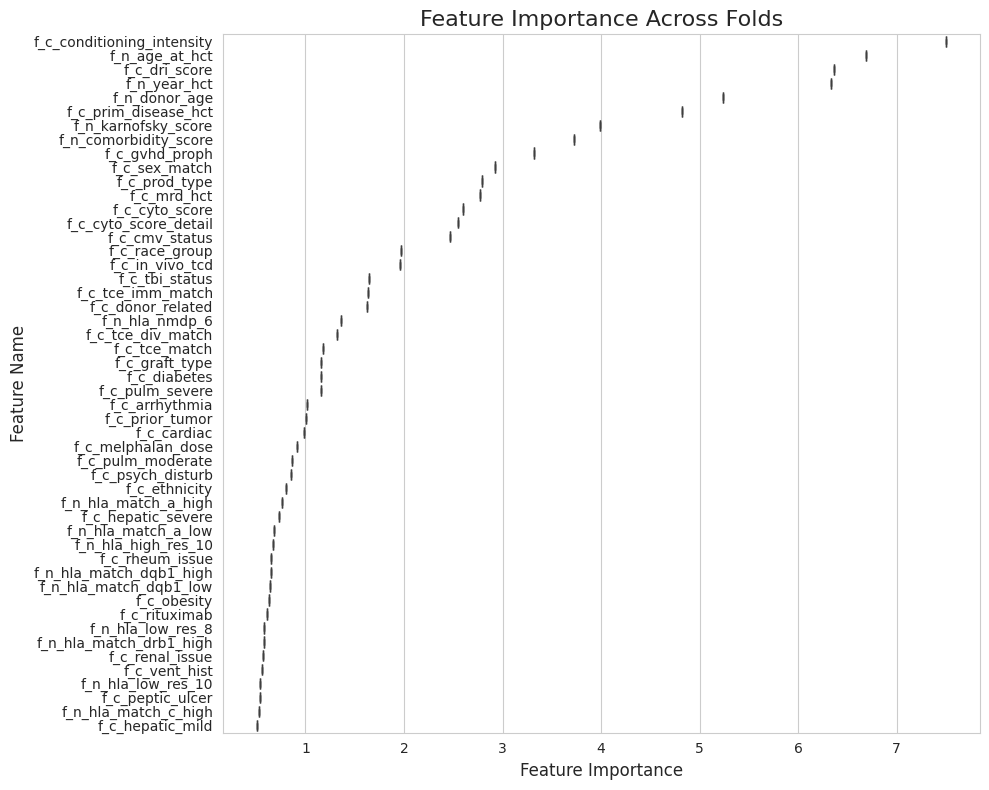

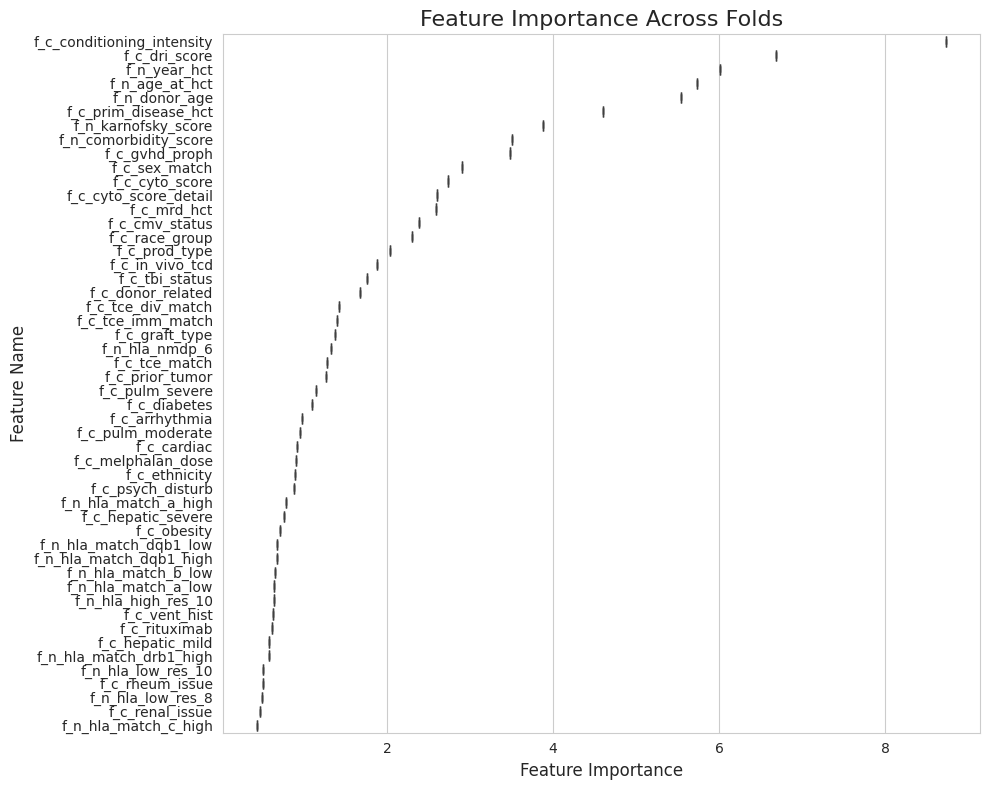

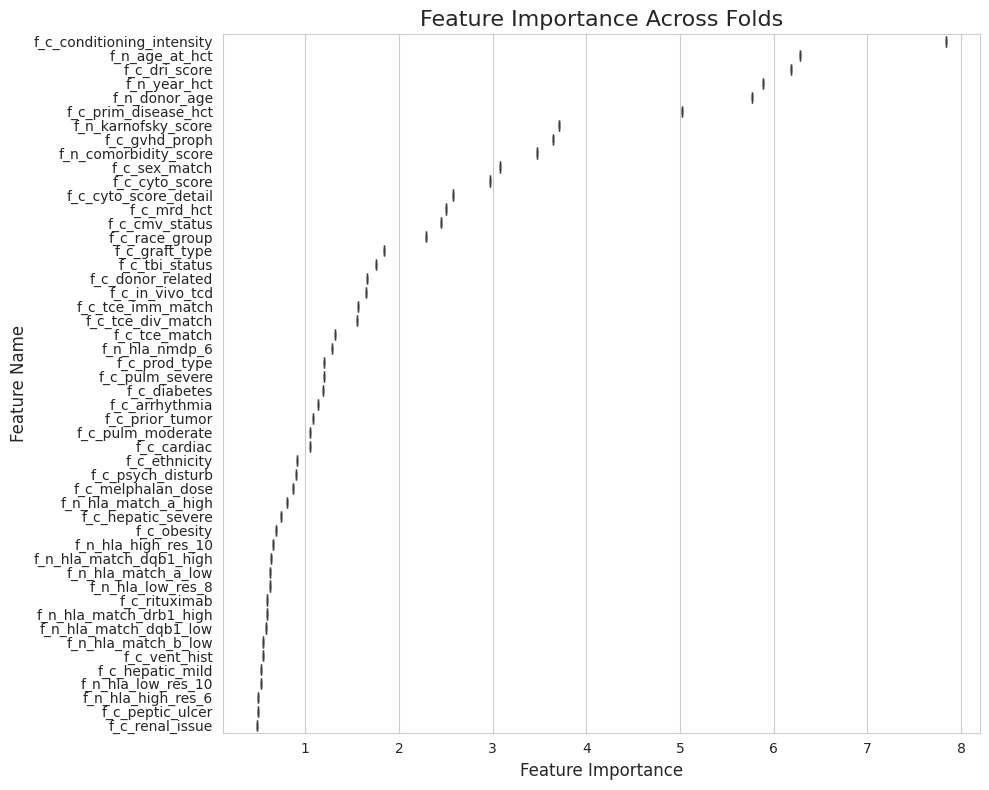

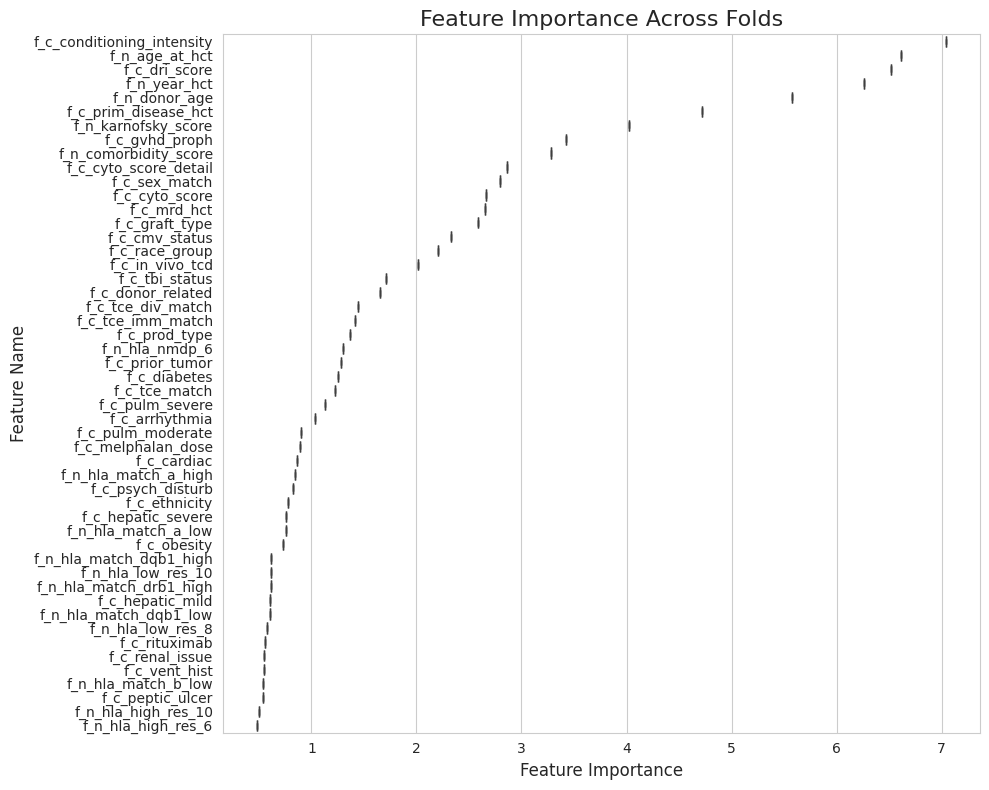

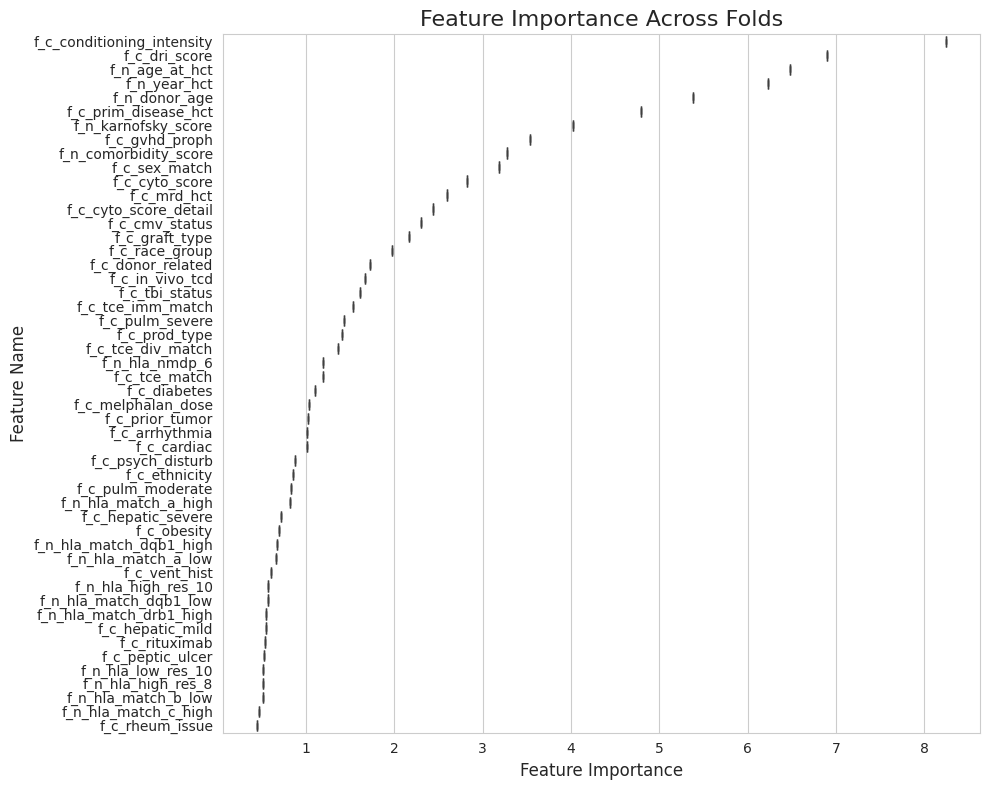

In [3]:
va_result_df, va_scores = pl.DataFrame(), {}
for seed in config.SEEDS:
    name = f"cat_{seed}"
    _va_result_df, _va_scores, trained_models = single_train_fn(
        model=CatBoostRegressorWrapper(
            name=name,
            model=CatBoostRegressor(
                loss_function="Tweedie:variance_power=1.5",
                learning_rate=0.05,
                n_estimators=100000,
                early_stopping_rounds=2000,
                # eval_metric=CatBoostMetric(),
                verbose=100,
                random_state=seed,
                colsample_bylevel=0.2,
            ),
            multi_output=False,
            feature_names=feature_names,
            cat_features=cat_features,
        ),
        features_df=add_kfold(
            features_df,
            n_splits=config.N_SPLITS,
            random_state=seed,
            fold_col=config.FOLD_COL,
        ),
        feature_cols=feature_names,
        target_col="t_kmf_event_scaled2",
        fold_col=config.FOLD_COL,
        meta_cols=config.META_COLS,
        weight_col="weight",
        out_dir=config.OUTPUT_DIR,
        train_folds=None,
        eval_fn=Metric(),
        overwrite=True,
        # use_eval_metric_extra_va_df=True,
    )
    va_result_df = pl.concat([va_result_df, _va_result_df], how="diagonal_relaxed")
    va_scores[name] = _va_scores

# ------------------------------
# final score
# ------------------------------
va_result_agg_df = (
    va_result_df.group_by(config.ID_COL)
    .agg(pl.col("pred").mean())
    .sort("ID")
    .join(train_test_df.select(config.META_COLS), on=config.ID_COL, how="left")
)
final_score = Metric()(input_df=va_result_agg_df)
logger.info(f"✅ final score: {final_score}")
va_scores["final"] = final_score

# save
va_result_agg_df.write_csv(f"{config.OUTPUT_DIR}/va_result.csv")
with open(f"{config.OUTPUT_DIR}/va_scores.json", "w") as f:
    json.dump(va_scores, f, indent=4)


In [4]:
# debug test
test_features_df = fe(config=config, train_test_df=train_test_df, output_dataset="TEST")
te_result_df = pl.DataFrame()
for seed in config.SEEDS:
    name = f"cat_{seed}"

    _te_result_df = single_inference_fn(
        model=CatBoostRegressorWrapper(name=name, feature_names=feature_names, cat_features=cat_features),
        features_df=test_features_df,
        feature_names=feature_names,
        model_dir=config.ARTIFACT_EXP_DIR(),
        inference_folds=list(range(config.N_SPLITS)),
        out_dir=config.OUTPUT_DIR,
    )
    te_result_df = pl.concat([te_result_df, _te_result_df], how="diagonal_relaxed")

te_result_agg_df = (
    te_result_df.group_by(config.ID_COL)
    .agg(pl.col("pred").mean())
    .sort("ID")
    .join(train_test_df.select(config.META_COLS), on=config.ID_COL, how="left")
)


print(te_result_agg_df["pred"].to_list())

INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 0 =============
INFO:src.trainer.tabular.simple:   - ✅ Successfully loaded model
INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 1 =============
INFO:src.trainer.tabular.simple:   - ✅ Successfully loaded model
INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 2 =============
INFO:src.trainer.tabular.simple:   - ✅ Successfully loaded model
INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 3 =============
INFO:src.trainer.tabular.simple:   - ✅ Successfully loaded model
INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 4 =============
INFO:src.trainer.tabular.simple:   - ✅ Successfully loaded model
INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 5 =============
INFO:src.trainer.tabular.simple:   - ✅ Successfully loaded model
INFO:src.trainer.tabular.simple:🚀 >>> Start training fold 6 =============
INFO:src.trainer.tabular.simple:   - ✅ Successfully loaded model
INFO:src.trainer.tabular.si

[1.2472953198900716, 2.080687789713642, 1.058382741773501]
